In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# read woe csv files

train_woe = pd.read_csv("datasets/train_woe.csv")
test_woe = pd.read_csv("datasets/test_woe.csv")

**Train Test Split**

In [3]:
X_train = train_woe.loc[:,train_woe.columns != 'target']
y_train = train_woe.loc[:,'target']
X_test = test_woe.loc[:,test_woe.columns != 'target']
y_test = test_woe.loc[:,'target']

**SMOTE**

In [4]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(X_train, y_train)

**XGBoost**

In [5]:
from xgboost import XGBClassifier

In [6]:
xgb = XGBClassifier(use_label_encoder = False, eval_metric = "logloss")
xgb.fit(X_balanced, y_balanced)
train_score = xgb.score(X_balanced, y_balanced)
test_score = xgb.score(X_test, y_test)
xgb_pred = xgb.predict(X_test)
print(train_score)
print(test_score)

0.9971499660710247
0.9924375841707241


In [7]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9474
           1       0.92      0.65      0.76       179

    accuracy                           0.99      9653
   macro avg       0.96      0.82      0.88      9653
weighted avg       0.99      0.99      0.99      9653



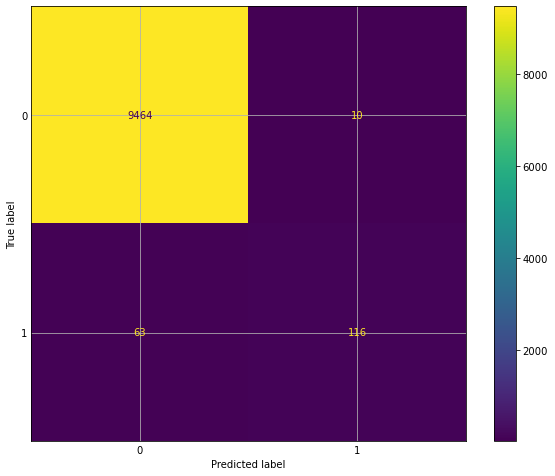

In [8]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, xgb_pred)
cmd = ConfusionMatrixDisplay(mat)
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

In [9]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

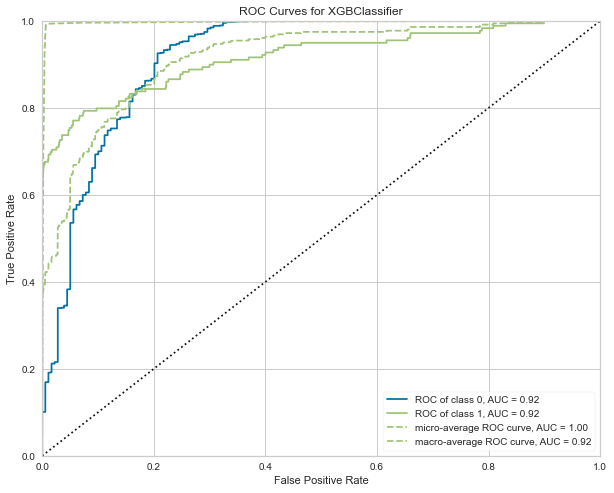

In [10]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(xgb, X_balanced, y_balanced, X_test, y_test)
plt.show()